# BM4D Experiment

In [1]:
import os
import time

import bm4d
import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image
from module.datasets import load_4d_dicom, save_4d_dicom

import h5py

from tqdm.notebook import tqdm


## Load dataset

In [2]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gauss_0.009.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

# set noise level 
noise_level = 0.009

Noisy data...float64 (shape:(24, 71, 192, 192); range:[-0.018414393986850297,1.0298518324719883]; mean:0.5030665574527993); std:0.02335746313650884
b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'


## Example denoising 

noisy_image: dtype:float64 range(0.40095936420489114,1.01743689314847) mean:0.5026486778473855 std:0.02246752868371976
denoised_image: dtype:float64 range(0.41128987073898315,1.011122703552246) mean:0.5026500139244315 std:0.020542513413629827
calculate_metrics running: 2.5481422934681177 second
PSNR: 37.021798508945054; SSIM: 0.827657023268938; MAE: 0.006926084100701063; BRISQUE: 111.99093237375116


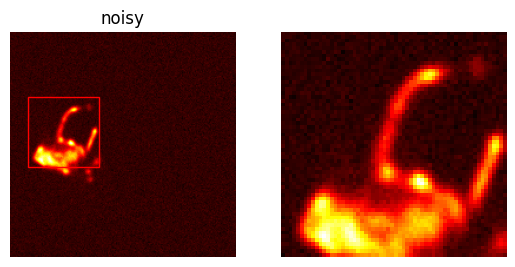

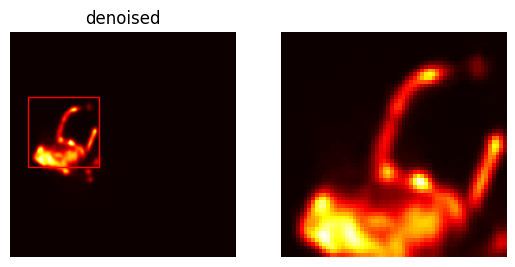

In [4]:
# demonstrate 
time_idx = 11
depth_idx = 38


#
noisy_image = noisy_data[time_idx]
print(f"noisy_image: dtype:{noisy_image.dtype} range({np.min(noisy_image)},{np.max(noisy_image)}) mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")


# process denoising
denoised_image = bm4d.bm4d(noisy_image, noise_level)
print(f"denoised_image: dtype:{denoised_image.dtype} range({np.min(denoised_image)},{np.max(denoised_image)}) mean:{np.mean(denoised_image)} std:{np.std(denoised_image)}")


# calculate PSNR, SSIM and MAE
data_range_denoised = np.max(denoised_image) - np.min(denoised_image)
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range = max(data_range_denoised, data_range_noisy)
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_image, noisy_image, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.mean(mae_values)}; BRISQUE: {np.mean(brisque_values)}")


# show result
zoom_coordinates = (55, 15, 60, 60)
display_image_in_detail(noisy_image[depth_idx], title='noisy')
display_image_in_detail(denoised_image[depth_idx], title='denoised')

## Process denoising

In [5]:
# denoised 
@timer_decorator
def process(noisy_data, noise_level):
    denoised_data = np.zeros_like(noisy_data)
    with tqdm(total=noisy_data.shape[0]) as pbar:
        for i in range(noisy_data.shape[0]):
            sub_image = noisy_data[i, :, :, :]
            denoised_sub_image = bm4d.bm4d(sub_image, noise_level)
            denoised_data[i, :, :, :] = denoised_sub_image
            pbar.update(1)
    return denoised_data


denoised_data = process(noisy_data, noise_level)
            
print(f"denoised_data: dtype:{denoised_data.dtype} range({np.min(denoised_data)},{np.max(denoised_data)}) mean:{np.mean(denoised_data)} std:{np.std(denoised_data)}")

  0%|          | 0/24 [00:00<?, ?it/s]

process running: 4536.886227877811 second
denoised_data: dtype:float64 range(-0.01772739738225937,1.0237685441970825) mean:0.5030646884255036 std:0.021465608171335013


## Evaluation

Calculate PSNR, SSIM

In [6]:
# calcualte PSNR, SSIM between denoised data and noisy data
data_range_noisy = np.max(noisy_data) - np.min(noisy_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, noisy_data, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.mean(mae_values)}; BRISQUE: {np.mean(brisque_values)}")

data range: 1.0482662264588387
calculate_metrics running: 48.17819448374212 second
PSNR: 41.66514026719329; SSIM: 0.9317916493552182; MAE: 0.006896721153925879; BRISQUE: 107.6415476240853


## Save denormalized denoised image into int16 DICOM file

In [7]:
# denormalzied denoised data
mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

display_4d_image(denormalized_denoised_data)

denormalized_denoised_data: dtype:int16 range(-32768,32767) mean:200.72923086979267 std:1406.5552439739122


interactive(children=(IntSlider(value=0, description='Time', max=23), IntSlider(value=0, description='Slice', …

In [8]:
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_gauss_0.009'

save_4d_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)

Processing time points: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]

Saved 1704 denoised DICOM files.
